In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.io as skio
from skimage.io import imread, imshow
from skimage.color import rgb2hsv
from skimage.exposure import histogram, cumulative_distribution
from skimage.filters import threshold_otsu
import cv2 as cv
from osgeo import gdal,ogr,osr
from skimage import filters
from skimage import feature
from cv2 import GaussianBlur
from PIL import Image
from skimage.feature import local_binary_pattern
from osgeo import gdal
import numpy as np

In [2]:
from skimage.segmentation import slic
from skimage.color import label2rgb
from skimage import io
import matplotlib.pyplot as plt
import cv2
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from osgeo import gdal
import numpy as np
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray
from skimage.measure import regionprops


In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from osgeo import gdal

# with rasterio.open(r'F:\wenqu\Aviris\classification\masked_aviris_trait\site7_sla_ymax.tif') as src:
#     img = src.read()
# # Convert image to 32-bit floating point
# img = np.transpose(img, (1, 2, 0))
# img_rgb = img.astype(np.uint8)

In [7]:
import rasterio

# Load the original image with rasterio to get metadata
with rasterio.open(r'F:\wenqu\Aviris\aviris_rgb_tif\site7.tif') as src:
    profile = src.profile

# Update the metadata for the grayscale image
profile.update(dtype=rasterio.uint8, count=1,  nodata=None)

# Save the grayscale image with the same reference system
output_path = r'F:\wenqu\segmentation\superpixel\gamma_img.tif'
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(gamma_img, 1)

In [3]:
# # Ensure img_rgb is a 2D array first, by removing the singleton dimension if necessary
# if img_rgb.shape[2] == 1:
#     img_rgb = img_rgb.squeeze()

# # Convert the 2D grayscale image to a 3-channel BGR image
# img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_GRAY2BGR)

In [4]:
# Open the TIFF file
dataset = gdal.Open(r'F:\wenqu\Aviris\classification\masked_aviris_trait\site7_sla_ymax.tif', gdal.GA_ReadOnly)

In [5]:
# Read the first band
band = dataset.GetRasterBand(1)
img = band.ReadAsArray()

# Get nodata value
nodata_value = band.GetNoDataValue()
if nodata_value is not None:
    mask = img != nodata_value
else:
    mask = np.ones_like(img, dtype=bool)  # Assume all data is valid if no nodata value is set

# Masked array to ignore nodata values
masked_img = np.ma.masked_array(img, ~mask)

# Normalize the valid data
min_val = masked_img.min()
max_val = masked_img.max()

# Avoid division by zero if the image is flat
if max_val != min_val:
    normalized_img = (masked_img - min_val) * 255 / (max_val - min_val)
else:
    normalized_img = np.ma.masked_array(np.zeros_like(masked_img), mask=~mask)

# Fill nodata areas in the normalized image
gray = normalized_img.astype(np.uint8)
smoothed = cv2.GaussianBlur(gray, (3, 3), 0)

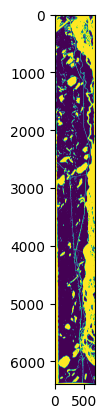

In [6]:
#binary thresholding and otsu's method can find optimal threhsold
ret, thresh = cv2.threshold(smoothed,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.imshow(thresh)

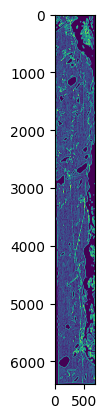

In [7]:
adaptive_thresh = cv2.adaptiveThreshold(smoothed, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                        cv2.THRESH_BINARY_INV, 11, 2)
plt.imshow(adaptive_thresh)

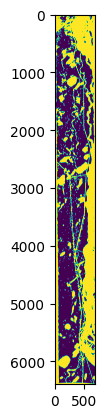

In [8]:
kernel = np.ones((3,3), np.uint8)
sure_bg = cv2.dilate(thresh, kernel, iterations=3)
plt.imshow(sure_bg)

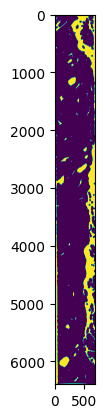

In [9]:
dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.01*dist_transform.max(), 255, 0)
plt.imshow(sure_fg)

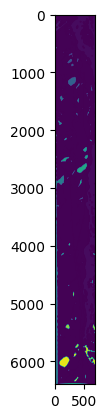

In [10]:
# 寻找未知区域
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# 标记标签
ret, markers = cv2.connectedComponents(sure_fg)

# 为所有的标记加1，确保背景是0而不是1
markers = markers + 1

# 标记未知区域为0
markers[unknown==255] = 0

plt.imshow(markers)

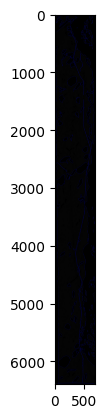

In [12]:
# 转换图像为3通道，以满足watershed算法的要求
img_color = cv2.cvtColor(img_rgb, cv2.COLOR_GRAY2BGR)

# 应用分水岭算法
markers = cv2.watershed(img_color, markers)
img_color[markers == -1] = [255, 0, 0]  # 将边界标记为红色

# 显示结果
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))  # 确保以RGB格式显示
plt.show()

In [ ]:
# 步骤4: 应用分水岭算法
markers = cv2.watershed(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), markers)
img[markers == -1] = [255]  # 将边界标记为白色

# 步骤5: 显示结果
plt.imshow(markers, cmap='jet')  # 使用颜色图显示分割结果
plt.show()

In [15]:
import rasterio

# Load the original image with rasterio to get metadata
with rasterio.open(r'F:\wenqu\Aviris\aviris_rgb_tif\site7.tif') as src:
    profile = src.profile

# Update the metadata for the grayscale image
profile.update(dtype=rasterio.uint8, count=1,  nodata=None)

# Save the grayscale image with the same reference system
output_path = r'F:\wenqu\segmentation\superpixel\img_color.tif'
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(img_color[:,:,0], 1)